## Image Classifier with CNN

In [3]:
import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


In [4]:
import subprocess

# Configurar la GPU para que TensorFlow pueda usarla
physical_devices = tf.config.list_physical_devices('GPU')
if len(physical_devices) == 0:
    print("No se encontraron GPUs. TensorFlow está utilizando la CPU.")
else:
    tf.config.experimental.set_memory_growth(physical_devices[0], True)
    print("TensorFlow está utilizando la GPU: ", physical_devices[0])
    print("El nombre de mi placa es : ", tf.test.gpu_device_name())
    try:
        result = subprocess.run(['nvidia-smi', '--query-gpu=name', '--format=csv,noheader,nounits'], stdout=subprocess.PIPE, stderr=subprocess.PIPE, universal_newlines=True)
        gpu_name = result.stdout.strip()
        print("Nombre de la tarjeta gráfica: ", gpu_name)
        print("CUDA activado: ", tf.test.is_built_with_cuda())
    except Exception as e:
        print("Error al obtener el nombre de la GPU:", e)


TensorFlow está utilizando la GPU:  PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')
El nombre de mi placa es :  /device:GPU:0
Nombre de la tarjeta gráfica:  NVIDIA GeForce RTX 2060 SUPER
CUDA activado:  True


---

In [5]:
from keras.datasets import mnist
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
from keras.models import Sequential
from keras.layers import Dense, Flatten
import openpyxl

In [6]:
classes = [f for f in os.listdir('movie_dataset/train')]
print(classes)

['El caballero oscuro', 'El padrino', 'El señor de los anillos El retorno del rey', 'Titanic']


In [7]:
#Exploramos las carpetas...
import os
for dir, dirname, files in os.walk('movie_dataset'):
  print(f"Dir: {dir} | subdir: {dirname} | cant de imagenes: {len(files)} ")

Dir: movie_dataset | subdir: ['test', 'train'] | cant de imagenes: 0 
Dir: movie_dataset\test | subdir: ['El caballero oscuro', 'El padrino', 'El señor de los anillos El retorno del rey', 'Titanic'] | cant de imagenes: 0 
Dir: movie_dataset\test\El caballero oscuro | subdir: [] | cant de imagenes: 250 
Dir: movie_dataset\test\El padrino | subdir: [] | cant de imagenes: 250 
Dir: movie_dataset\test\El señor de los anillos El retorno del rey | subdir: [] | cant de imagenes: 250 
Dir: movie_dataset\test\Titanic | subdir: [] | cant de imagenes: 250 
Dir: movie_dataset\train | subdir: ['El caballero oscuro', 'El padrino', 'El señor de los anillos El retorno del rey', 'Titanic'] | cant de imagenes: 0 
Dir: movie_dataset\train\El caballero oscuro | subdir: [] | cant de imagenes: 250 
Dir: movie_dataset\train\El padrino | subdir: [] | cant de imagenes: 250 
Dir: movie_dataset\train\El señor de los anillos El retorno del rey | subdir: [] | cant de imagenes: 250 
Dir: movie_dataset\train\Titanic

In [8]:
classes = [f for f in os.listdir('movie_dataset/train')]
print(classes)

['El caballero oscuro', 'El padrino', 'El señor de los anillos El retorno del rey', 'Titanic']


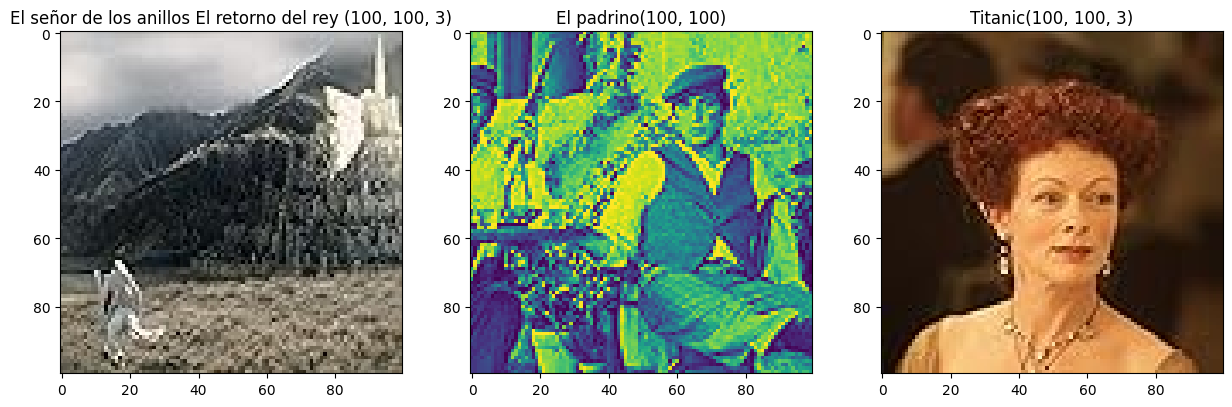

In [9]:
import matplotlib.pyplot as plt
import random, os

plt.figure(figsize=(15,7))
id = random.choice(range(0,16))
plt.subplot(1,3,1)
img_name = [f for f in os.listdir('movie_dataset/train/El señor de los anillos El retorno del rey/')][id]
img = plt.imread('movie_dataset/train/El señor de los anillos El retorno del rey/'+img_name)
plt.imshow(img)
plt.title('El señor de los anillos El retorno del rey '+str(img.shape))
plt.subplot(1,3,2)
img_name = [f for f in os.listdir('movie_dataset/train/El padrino/')][id]
img = plt.imread('movie_dataset/train/El padrino/'+img_name)
plt.imshow(img)
plt.title('El padrino'+str(img.shape))
plt.subplot(1,3,3)
img_name = [f for f in os.listdir('movie_dataset/train/Titanic/')][id]
img = plt.imread('movie_dataset/train/Titanic/'+img_name)
plt.imshow(img)
plt.title('Titanic'+str(img.shape));

In [10]:
#Exploramos los características de las imágenes
list_img_film = [f for f in os.listdir('movie_dataset/train/Titanic')]
test_img = plt.imread('movie_dataset/train/Titanic/'+random.choice(list_img_film)) #Elegimos la primera de las imágenes de la lista para leerlas
print(f"Shape de la imagen: {test_img.shape}")
print(f"Dimensiones de la imagen: {test_img.ndim}")
print(f"Codificación la imagen: {test_img.dtype}")
print(f"Pixel de mayor valor: {test_img.max()}")
print(f"Pixel de menor valor: {test_img.min()}")

Shape de la imagen: (100, 100, 3)
Dimensiones de la imagen: 3
Codificación la imagen: uint8
Pixel de mayor valor: 255
Pixel de menor valor: 0


In [11]:
import tensorflow as tf
print(f"Version: {tf.version}")

Version: <module 'tensorflow._api.v2.version' from 'c:\\Users\\Nicolas\\anaconda3\\envs\\mc_env\\lib\\site-packages\\tensorflow\\_api\\v2\\version\\__init__.py'>


Entrenamos el Modelo

In [12]:
import tensorflow as tf

# Configuración de la semilla aleatoria para reproducibilidad
tf.random.set_seed(42)

# Directorios de entrenamiento y prueba
train_dir = 'movie_dataset/train/'
test_dir = 'movie_dataset/test/'

# Data augmentation
# Generadores de datos de entrenamiento y prueba con normalización y aumento de datos
train_generator = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255,
    horizontal_flip=True,
    vertical_flip=True,
    rotation_range=30,       # Aumento de rotación
    width_shift_range=0.2,   # Aumento de cambio de ancho
    height_shift_range=0.2,  # Aumento de cambio de alto
    shear_range=0.2,         # Distorción
    zoom_range=0.2           # Aumento de zoom
)

test_generator = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255)

train_batch = train_generator.flow_from_directory(
    train_dir,
    target_size=(224, 224),
    batch_size=240,
    class_mode='categorical'
)

test_batch = test_generator.flow_from_directory(
    test_dir,
    target_size=(224, 224),
    batch_size=240,
    class_mode='categorical'
)

Found 1000 images belonging to 4 classes.
Found 1000 images belonging to 4 classes.


In [13]:
model_cnn = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(32,(3,3), activation='relu', input_shape=(224,224,3)),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(64,(3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(128,(3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
 
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dense(4, activation='softmax')
])

model_cnn.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 222, 222, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 111, 111, 32)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 109, 109, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 54, 54, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 52, 52, 128)       73856     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 26, 26, 128)      0

In [14]:
# Compilación del modelo
model_cnn.compile(
    optimizer=tf.keras.optimizers.Adam(), #learning_rate=0.0001
    loss=tf.keras.losses.CategoricalCrossentropy(),
    metrics=['accuracy']
)

In [15]:
from tensorflow.keras.callbacks import TensorBoard
tensorboardDenso = TensorBoard(log_dir='logs')

In [16]:
# Entrenamiento del modelo
model_cnn.fit(
    train_batch,
    epochs=200,
    validation_data=test_batch,
    callbacks=[
        tensorboardDenso,
        tf.keras.callbacks.EarlyStopping(patience=10),
        tf.keras.callbacks.ReduceLROnPlateau(patience=5)
    ]
)

Epoch 1/200
5/5 [==============================] - 185s 9s/step - loss: 2.2439 - accuracy: 0.2660 - val_loss: 1.4081 - val_accuracy: 0.2500 - lr: 0.0010
Epoch 2/200
5/5 [==============================] - 42s 8s/step - loss: 1.3647 - accuracy: 0.2990 - val_loss: 1.3421 - val_accuracy: 0.3230 - lr: 0.0010
Epoch 3/200
5/5 [==============================] - 41s 10s/step - loss: 1.3058 - accuracy: 0.3500 - val_loss: 1.2687 - val_accuracy: 0.4560 - lr: 0.0010
Epoch 4/200
5/5 [==============================] - 40s 7s/step - loss: 1.2676 - accuracy: 0.4390 - val_loss: 1.2340 - val_accuracy: 0.4340 - lr: 0.0010
Epoch 5/200
5/5 [==============================] - 41s 7s/step - loss: 1.2327 - accuracy: 0.4790 - val_loss: 1.2028 - val_accuracy: 0.4730 - lr: 0.0010
Epoch 6/200
5/5 [==============================] - 42s 8s/step - loss: 1.2289 - accuracy: 0.4790 - val_loss: 1.1917 - val_accuracy: 0.4960 - lr: 0.0010
Epoch 7/200
5/5 [==============================] - 41s 10s/step - loss: 1.1900 - accur

In [17]:
# Evaluación del modelo en el conjunto de prueba
test_accuracy = model_cnn.evaluate(test_batch)

5/5 [==============================] - 2s 333ms/step - loss: 0.5194 - accuracy: 0.8090


In [18]:
import tensorflow as tf

# Comprobar si hay GPUs disponibles
gpus = tf.config.experimental.list_physical_devices('GPU')
if not gpus:
    print("No se encontraron GPUs. TensorFlow está utilizando la CPU.")
else:
    # Configurar para que TensorFlow use la primera GPU (puedes ajustar el índice si tienes varias GPUs)
    tf.config.experimental.set_memory_growth(gpus[0], True)

In [19]:
import tensorflow as tf
from tensorflow.keras.applications import MobileNetV2

# Configuración de la semilla aleatoria para reproducibilidad
tf.random.set_seed(42)

# Directorios de entrenamiento y prueba
train_dir = 'movie_dataset/train/'
test_dir = 'movie_dataset/test/'

# Data augmentation
train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255,
    horizontal_flip=True,
    vertical_flip=True,
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2
)

test_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255)

# Cargar el modelo pre-entrenado MobileNetV2 sin incluir la capa superior
base_model = MobileNetV2(input_shape=(224, 224, 3), include_top=False, weights='imagenet')

# Congelar las capas del modelo base
for layer in base_model.layers:
    layer.trainable = False

# Agregar capas adicionales para la clasificación de películas
x = tf.keras.layers.GlobalAveragePooling2D()(base_model.output)
x = tf.keras.layers.Dense(256, activation='relu')(x)
predictions = tf.keras.layers.Dense(4, activation='softmax')(x)

model_transfer = tf.keras.Model(inputs=base_model.input, outputs=predictions)

# Compilación del modelo
model_transfer.compile(
    optimizer=tf.keras.optimizers.Adam(lr=0.0001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Entrenamiento del modelo
train_batch = train_datagen.flow_from_directory(
    train_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical'
)

test_batch = test_datagen.flow_from_directory(
    test_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical'
)
# Asegurarse de que TensorFlow esté configurado para utilizar la GPU
with tf.device('/device:GPU:0'):
    # Tu código de entrenamiento aquí
    model_transfer.fit(
        train_batch,
        epochs=200,
        validation_data=test_batch,
        callbacks=[
            tf.keras.callbacks.EarlyStopping(patience=10),
            tf.keras.callbacks.ReduceLROnPlateau(patience=5)
        ]
    )

# Evaluación del modelo en el conjunto de prueba
test_accuracy = model_transfer.evaluate(test_batch, verbose=2)


Found 1000 images belonging to 4 classes.
Found 1000 images belonging to 4 classes.


c:\Users\Nicolas\anaconda3\envs\mc_env\lib\site-packages\keras\optimizers\optimizer_v2\adam.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


Epoch 1/200
32/32 [==============================] - 134s 4s/step - loss: 1.3307 - accuracy: 0.3720 - val_loss: 1.1732 - val_accuracy: 0.4720 - lr: 1.0000e-04
Epoch 2/200
32/32 [==============================] - 141s 4s/step - loss: 1.0496 - accuracy: 0.5730 - val_loss: 1.0070 - val_accuracy: 0.5930 - lr: 1.0000e-04
Epoch 3/200
32/32 [==============================] - 140s 4s/step - loss: 0.8586 - accuracy: 0.6740 - val_loss: 0.8867 - val_accuracy: 0.6640 - lr: 1.0000e-04
Epoch 4/200
32/32 [==============================] - 61s 2s/step - loss: 0.7634 - accuracy: 0.7270 - val_loss: 0.7836 - val_accuracy: 0.7320 - lr: 1.0000e-04
Epoch 5/200
32/32 [==============================] - 41s 1s/step - loss: 0.6727 - accuracy: 0.7530 - val_loss: 0.7227 - val_accuracy: 0.7570 - lr: 1.0000e-04
Epoch 6/200
32/32 [==============================] - 41s 1s/step - loss: 0.6427 - accuracy: 0.7690 - val_loss: 0.6991 - val_accuracy: 0.7530 - lr: 1.0000e-04
Epoch 7/200
32/32 [==============================

In [20]:
%load_ext tensorboard

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


In [21]:
%tensorboard --logdir logs

Reusing TensorBoard on port 6006 (pid 42632), started 1:19:42 ago. (Use '!kill 42632' to kill it.)

Guardamos nuestros modelos

In [22]:
model_cnn.save('films_classifier.h5')

In [23]:
model_transfer.save('films_classifier_mobilenet.h5')

In [24]:
from tensorflow.keras.models import load_model

loaded_model_cnn = load_model('films_classifier.h5')

In [25]:
from tensorflow.keras.models import load_model

loaded_model = load_model('films_classifier_mobilenet.h5')

In [26]:
mkdir output_directory

In [27]:
!tensorflowjs_converter --input_format keras films_classifier.h5 output_directory

In [28]:
mkdir output_directory_mobilenet

In [29]:
!tensorflowjs_converter --input_format keras --output_format tfjs_graph_model films_classifier_mobilenet.h5 output_directory_mobilenet

Writing weight file output_directory_mobilenet\model.json...


In [30]:
# Realizamos una predicción

# Elegimos una imagen de prueba
img = plt.imread(r'movie_dataset\test\El padrino\252.jpg')

# Reescalamos la imagen para introducirla al modelo
img = img/255.

# Ajustamos las dimensiones de la imagen
img.resize((224,224,3))
img_exp = tf.expand_dims(img, axis=0)

y_pred = model_cnn.predict(img_exp)
print(f"Predicción: {y_pred}") # Softmax

1/1 [==============================] - 1s 1s/step
Predicción: [[1.0000000e+00 9.1530495e-25 1.0107084e-21 1.1512291e-24]]


In [31]:
y_pred = tf.squeeze(y_pred)
tf.math.reduce_sum(y_pred).numpy()

1.0

In [32]:
tf.argmax(y_pred).numpy()

0

In [33]:
y_pred = tf.squeeze(y_pred)
y_pred = tf.round(y_pred)
print(f"Predicción de la imagen: {y_pred}") # Argmax

Predicción de la imagen: [1. 0. 0. 0.]


In [34]:
# Retornar el indice mayor de todos los items
y_pred = tf.argmax(y_pred)
print(f"La clase es: {classes[y_pred]}")

La clase es: El caballero oscuro


In [35]:
# Realizamos una predicción 2

from tensorflow.keras.preprocessing import image

test_image_path = r'movie_dataset\test\El señor de los anillos El retorno del rey\270.jpg'

test_image = image.load_img(test_image_path, target_size=(224, 224))
test_image = image.img_to_array(test_image)
test_image = np.expand_dims(test_image, axis=0)
test_image = test_image / 255.0  # Normalizar la imagen

predictions = model_cnn.predict(test_image)

class_labels = ['El caballero oscuro', 'El padrino', 'El señor de los anillos: El retorno del rey', 'Titanic']
predicted_class = class_labels[np.argmax(predictions)]

print(f'Predicción: {predicted_class}')

1/1 [==============================] - 0s 90ms/step
Predicción: El señor de los anillos: El retorno del rey


In [36]:
# Realizamos una predicción MobileNetV2
import numpy as np
from tensorflow.keras.preprocessing import image

test_image_path = r'movie_dataset\test\El señor de los anillos El retorno del rey\262.jpg'

test_image = image.load_img(test_image_path, target_size=(224, 224))
test_image = image.img_to_array(test_image)
test_image = np.expand_dims(test_image, axis=0)
test_image = test_image / 255.0  # Normalizar la imagen

predictions = model_transfer.predict(test_image)

class_labels = ['El caballero oscuro', 'El padrino', 'El señor de los anillos: El retorno del rey', 'Titanic']
predicted_class = class_labels[np.argmax(predictions)]

print(f'Predicción: {predicted_class}')

1/1 [==============================] - 3s 3s/step
Predicción: El señor de los anillos: El retorno del rey
